In [ ]:
# default_exp data_processing
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    # device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
    # no one needs to do dataset stuff on CPU
    device = torch.device('cpu')
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
%load_ext autoreload
%autoreload 2

Using device cpu


# 02d Flow Datasets
> Here be the tailored datasets for FRED! In addition to storing points, we must store a graph, and intelligently sample from the graph so that batches preserve 'flow neighborhoods'

As previously listed, this is our preprocessing pipeline.

0. Turn data to torch tensors
1. Build graph from data, using flashlight kernel
	1. Estimate best parameters for kernel selection
2. Take diffusion map on data (or any ‘best guess embedding’) we want to penalize against. (Can be done on CPU or GPU). Would likely use established methods, like PHATE, tSNE, node2vec.
	1. Visualize embedding
3. Find flow neighborhoods of data (possibly at multiple scales)
4. **Break data into batches (both affinity matrix of batches and points in batches).**
5. **Return `Dataloader` with minibatch `X` and subgraph `A` of each batch.**


0-3 are handled by separate functions. This notebook calls upon these functions, and implements the machinery for 4 and 5

# Two Types of Data
FRED can operate on both directed graphs (assumed to be sampled from a manifold with flow, ala the "Manifold with Flow" hypothesis) and pointclouds with associated velocity vectors (like RNA velocity single cell data). Each type is processed differently, and requires a different dataset class.

In [ ]:
# export
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import umap
import phate
from sklearn.neighbors import NearestNeighbors
import torch.nn.functional as F
from FRED.data_processing import flashlight_affinity_matrix, diffusion_map_from_affinities, flow_neighbors
class ManifoldWithVectorField(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, X, velocities, labels, sigma="automatic", flow_strength = 1, prior_embedding = "diffusion map", t_dmap = 1, dmap_coords_to_use = 2, phate_decay = 40, n_neighbors = 5, minibatch_size = 100, nbhd_strategy = "flow neighbors", verbose = False):
        # Step 0: Convert data into tensors
        self.X = torch.tensor(X).float()
        self.velocities = torch.tensor(velocities).float()
        self.labels = labels
        self.n_neighbors = n_neighbors
        self.nbhd_strategy = nbhd_strategy
        self.n_nodes = self.X.shape[0]
        self.minibatch_size = minibatch_size
        
        # Step 1. Build graph on input data, using flashlight kernel
        if verbose: print("Building flow affinity matrix")
        self.A = flashlight_affinity_matrix(self.X, self.velocities, sigma = sigma, flow_strength = flow_strength)
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        # visualize affinity matrix
        plt.imshow(self.A.numpy())

        # Step 2. Take a diffusion map of the data
        # These will become our 'precomputed distances' which we use to regularize the embedding
        if prior_embedding == "diffusion map":
            self.P_graph_symmetrized = self.P_graph + self.P_graph.T
            diff_map = diffusion_map_from_affinities(
                self.P_graph_symmetrized, t=t_dmap, plot_evals=False
            )
            self.diff_coords = diff_map[:, :dmap_coords_to_use]
            self.diff_coords = self.diff_coords.real
            self.diff_coords = torch.tensor(self.diff_coords.copy()).float()
            self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
            # scale distances between 0 and 1
            self.precomputed_distances = 2 * (
                self.precomputed_distances / torch.max(self.precomputed_distances)
            )
            self.precomputed_distances = (
                self.precomputed_distances.detach()
            )  # no need to have gradients from this operation
        elif prior_embedding == "UMAP":
            print("Computing UMAP")
            reducer = umap.UMAP()
            self.umap_coords = torch.tensor(reducer.fit_transform(self.X))
            self.precomputed_distances = torch.cdist(self.umap_coords, self.umap_coords).detach()
        elif prior_embedding == "PHATE":
            print(f"Computing PHATE with {phate_decay=} and {self.n_neighbors=}")
            print("X is",self.X)
            phate_op = phate.PHATE() #n_components = 2, decay=phate_decay, knn=self.n_neighbors
            self.phate_coords = phate_op.fit_transform(self.X)
            phate.plot.scatter2d(self.phate_coords, c=labels)
            self.phate_coords = torch.tensor(self.phate_coords)
            self.precomputed_distances = torch.cdist(self.phate_coords, self.phate_coords).detach()
        else:
            raise ValueError("Prior embedding must be either 'diffusion map' or 'UMAP'")
        # scale to have max dist 1
        self.precomputed_distances = self.precomputed_distances/torch.max(self.precomputed_distances)
        # Step 3: This returns a sparse representation of the flow neighborhoods, in the form of two tensors: row, col. The numbers in row specify the index, and the adjacent entries in col are the neighbors of that index.
        if nbhd_strategy == "flow neighbors":
            self.neighborhoods = flow_neighbors(self.n_nodes, self.P_graph, self.n_neighbors)
        if nbhd_strategy == "euclidean neighbors":
            # Get points with nearest diffusion distances, based on above computation with dmap on symmetrized
            # directed diffusion matrix
            Neighbors = NearestNeighbors(n_neighbors=self.n_neighbors).fit(self.X)
            dists, indxs = Neighbors.kneighbors()
            self.neighborhoods = torch.tensor(indxs)
    def neighbors_from_point(self, idx):
        if self.nbhd_strategy == "flow neighbors":
            # Returns list of idxs of neighbors of the given idx
            row, col = self.neighborhoods
            idxs = torch.squeeze(torch.nonzero(row == idx))
            return col[idxs]
        elif self.nbhd_strategy == "euclidean neighbors":
            return self.neighborhoods[idx]

    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        # Get the neighborhood around the central point
        nbhd_idxs = self.neighbors_from_point(idx)
        # And sample random points -- for negative sampling loss
        random_idxs = torch.tensor(np.random.choice(np.arange(self.n_nodes), size=(self.minibatch_size))).long()
        minibatch_idxs = torch.concat([torch.tensor([idx]), nbhd_idxs, random_idxs])
        # Compute miniature diffusion matrix
        A_batch = self.A[minibatch_idxs][:,minibatch_idxs]
        P_batch = F.normalize(A_batch, p=1, dim=1)
        # Get actual points
        X_batch = self.X[minibatch_idxs]
        # Get subset of distances
        mini_precomputed_distances = self.precomputed_distances[minibatch_idxs][:,minibatch_idxs]
        # compute sparse representation of neighborhood around idx
        row = torch.zeros(self.n_neighbors).long()
        col = torch.arange(1,self.n_neighbors+1).long()
        neighbors = torch.vstack(
            [row, col]
        )
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "P":P_batch,
            "X":X_batch,
            "num flow neighbors":self.n_neighbors,
            "precomputed distances": mini_precomputed_distances,
            "neighbors":neighbors,
            "labels":self.labels[minibatch_idxs],
        }
        return return_dict
    def all_data(self):
        return_dict = {
            "P":self.P_graph,
            "X":self.X,
            "num flow neighbors":self.n_neighbors,
            "precomputed distances":self.precomputed_distances,
            "neighbors": self.neighborhood,
        }
        return return_dict

# Version 2: Minimal Neighborhoods, combined with Batching

In [ ]:
# export
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
# used for precomputed a manifold embedding
import umap
import phate
from sklearn.neighbors import NearestNeighbors
# other functions from FRED, for computing flashlight affinities
from FRED.data_processing import flashlight_kernel, diffusion_map_from_affinities

class ManifoldWithVectorFieldV2(Dataset):
    """
    Dataset object to be used with FRED for pointcloud and velocity input data.
    Takes np.arrays for X (points) and velocities (velocity vectors per point).
    For each item retrieved, returns a neighborhood around that point (based on local euclidean neighbors) containing local affinities

    """
    def __init__(self, 
        X, # The input pointcloud
        velocities, # input velocities associated to each point
        labels, 
        sigma="automatic", 
        flow_strength = 1, 
        prior_embedding = "diffusion map", 
        directed_diffusion_time_steps = 8, 
        t_dmap = 1, # when sampling flow neighbors, consider this power of diffusion
        dmap_coords_to_use = 2, 
        phate_decay = 40, 
        n_neighbors = 5, 
        minibatch_size = 100, 
        nbhd_strategy = "flow neighbors", 
        verbose = False,
        ):
        # Step 0: Convert data into tensors; and send to floats, for compatibility with apple MPS
        self.X = torch.tensor(X).float()
        self.velocities = torch.tensor(velocities).float()
        self.labels = labels
        self.n_neighbors = n_neighbors
        self.nbhd_strategy = nbhd_strategy
        self.n_nodes = self.X.shape[0]
        self.minibatch_size = minibatch_size
        
        # Step 1. Build graph on input data, using flashlight kernel
        if verbose: print("Building flow affinity matrix")

        self.A = flashlight_kernel(self.X, self.velocities, kernel_type="adaptive anisotropic", k = n_neighbors,sigma=sigma, flow_strength=flow_strength)
        self.P_graph = F.normalize(self.A, p=1, dim=1)
        self.P_t = torch.linalg.matrix_power(self.P_graph,directed_diffusion_time_steps)
        # visualize affinity matrix, as a sanity check
        plt.imshow(self.A.numpy())

        # Step 2. Precompute an embedding of the data using a purely manifold-based technique
        # These will become our 'precomputed distances' which we use to regularize the embedding
        match prior_embedding:
            case "diffusion map":
                self.P_graph_symmetrized = self.P_graph + self.P_graph.T
                diff_map = diffusion_map_from_affinities(
                    self.P_graph_symmetrized, t=t_dmap, plot_evals=False
                )
                self.diff_coords = diff_map[:, :dmap_coords_to_use]
                self.diff_coords = self.diff_coords.real
                self.diff_coords = torch.tensor(self.diff_coords.copy()).float()
                self.precomputed_distances = torch.cdist(self.diff_coords, self.diff_coords)
                # scale distances between 0 and 1
                self.precomputed_distances = 2 * (
                    self.precomputed_distances / torch.max(self.precomputed_distances)
                )
                self.precomputed_distances = (
                    self.precomputed_distances.detach()
                )  # no need to have gradients from this operation
            case "UMAP":
                print("Computing UMAP")
                reducer = umap.UMAP()
                self.umap_coords = torch.tensor(reducer.fit_transform(self.X))
                self.precomputed_distances = torch.cdist(self.umap_coords, self.umap_coords).detach()
            case "PHATE":
                print(f"Computing PHATE with {phate_decay=} and {self.n_neighbors=}")
                print("X is",self.X)
                phate_op = phate.PHATE() #n_components = 2, decay=phate_decay, knn=self.n_neighbors
                self.phate_coords = phate_op.fit_transform(self.X)
                phate.plot.scatter2d(self.phate_coords, c=labels)
                self.phate_coords = torch.tensor(self.phate_coords)
                self.precomputed_distances = torch.cdist(self.phate_coords, self.phate_coords).detach()
            case _:
                raise NotImplementedError("Prior embedding must be either 'diffusion map' or 'UMAP'")
        # scale distances to have max dist 1, so that the same loss weights apply equally to all cases
        self.precomputed_distances = self.precomputed_distances/torch.max(self.precomputed_distances)

    def neighbor_from_point(self, idx:int) -> int:
        # Samples a flow neighbor from the t-step diffusion around the point idx, according
        # to the diffusion probabilities
        probs_from_idx = self.P_t[idx]
        # remove self-affinity and renormalize
        probs_from_idx[idx] = 0
        probs_from_idx = probs_from_idx / torch.sum(probs_from_idx)
        # Sample from the set of points according to this distribution
        sampled_idx = int(np.random.choice(np.arange(self.n_nodes), size = 1, p=probs_from_idx.numpy()))
        return sampled_idx

    def __len__(self):
        return self.n_nodes

    def __getitem__(self, idx):
        """
        Each item contains the central point *idx*, followed by a flow neighbor of that point, followed by a random point.
        The distances from the central point to the neighbor and random point are computed and stored.
        """
        # Get the neighborhood around the central point, as a set of pairs of points
        nbhr_idx = self.neighbor_from_point(idx)
        # And sample random points -- for negative sampling loss
        random_idx = int(np.random.choice(np.arange(self.n_nodes), size=1))
        minibatch_idxs = [idx, nbhr_idx, random_idx]
        # Get actual points
        X_batch = self.X[minibatch_idxs]
        # Get subset of distances; only store distances from idx to other points
        mini_precomputed_distances = self.precomputed_distances[minibatch_idxs][:,minibatch_idxs][0][1:] # we don't care about the self distance of 0
        # Embed these into a dictionary for easy cross reference
        return_dict = {
            "X":X_batch,
            "distance to neighbors": mini_precomputed_distances[0],
            "distance to farbors": mini_precomputed_distances[1],
            "labels":self.labels[minibatch_idxs],
        }
        return return_dict

## Testing

In [ ]:
from FRED.datasets import directed_swiss_roll_delayed
X, flow, labels = directed_swiss_roll_delayed(num_nodes=1000)

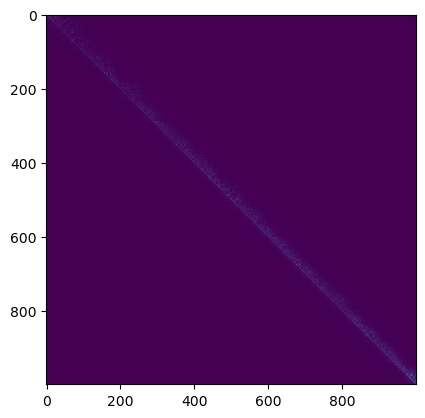

In [ ]:
ds = ManifoldWithVectorFieldV2(X, flow, labels)

In [ ]:
ds.__getitem__(1)

{'X': tensor([[ 0.0589, -4.7245,  5.0002],
         [ 6.0762, -0.8792,  2.7359],
         [ 4.3491, -3.5300,  3.2385]]),
 'distance to neighbors': tensor(0.1766),
 'distance to farbors': tensor(0.0664),
 'labels': array([4.72485784, 6.1394915 , 5.6013794 ])}

# Dataloaders
Because we're handling batching in a, shall we say, delicate way, the standard way of batching data doesn't work (without some downstream effort). In fact, we're treating each output element of the dataset as a batch by itself, so we can get nice behavior just by disabling batching entirely.

In [ ]:
# export
from torch.utils.data import default_collate
def FRED_collate(batch):
    # Compile into a dictionary of nested lists
    batch = default_collate(batch)
    # Combine these lists
    num_points = batch['X'].shape[0]*batch['X'].shape[1]
    data_dimension = batch['X'].shape[-1]
    batch['X'] = batch['X'].reshape(num_points,data_dimension)
    batch['labels'] = batch['labels'].reshape(num_points)
    # compile indices to neighbors and farbors
    center_point_idxs = torch.arange(0,len(batch['X']),step=3)
    neighbor_idxs = center_point_idxs + 1
    farbors_idxs = center_point_idxs + 2
    # add these to the batch
    batch['center point idxs'] = center_point_idxs.long()
    batch['neighbor idxs'] = neighbor_idxs.long()
    batch['farbor idxs'] = farbors_idxs.long()
    # TODO: Shuffle order of points
    return batch

In [ ]:
np.arange(0,12,step=3)

array([0, 3, 6, 9])

In [ ]:
from torch.utils.data import DataLoader
dataloader = DataLoader(ds, batch_size=5, collate_fn=FRED_collate, shuffle=True)

In [ ]:
for d in dataloader:
    print(d["X"].type())

torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.FloatTensor
torch.Floa

In [ ]:
d

{'X': tensor([[ 12.5949,   1.5250,   8.3086],
         [ 11.6140,   5.9251,   5.7580],
         [  9.8450,  -6.7950,  -3.8864],
         [  3.3085,  -4.2366,  -2.0046],
         [  4.9990,  -2.8665,  -5.3678],
         [  1.5114, -11.0287,  -5.3951],
         [ -7.5642,   4.6410,   0.8685],
         [ -9.4743,  -0.7546,   7.7331],
         [  5.2579,  -2.5296,   9.1507],
         [  6.2006,   2.4161,  -0.1798],
         [  6.0744,  12.2540,   4.3593],
         [ -0.7413, -10.9025,   2.8111],
         [  1.4435,  -4.7923,  -4.9032],
         [  4.7781,  -3.1173,  -2.2518],
         [  1.6401,   7.4594,   2.6696]]),
 'distance to neighbors': tensor([0.1653, 0.0429, 0.3070, 0.1822, 0.1227]),
 'distance to farbors': tensor([0.3404, 0.5827, 0.8567, 0.8706, 0.6917]),
 'labels': tensor([12.6869, 13.0381, 11.9623,  5.3754,  5.7625, 11.1318,  8.8744,  9.5043,
          5.8348,  6.6547, 13.6770, 10.9277,  5.0050,  5.7051,  7.6376],
        dtype=torch.float64),
 'center point idxs': tensor([ 0, 

# Convenience functions

In [ ]:
# export
from torch.utils.data import DataLoader
def dataloader_from_ndarray(X, flow, labels):
    ds = ManifoldWithVectorField(X, flow, labels)
    dataloader = DataLoader(ds, batch_size=None, shuffle=True)
    return dataloader

In [ ]:
dataloader.dataset.X

tensor([[ 1.1870e-02, -4.7149e+00, -4.5937e+00],
        [ 5.8912e-02, -4.7245e+00,  5.0002e+00],
        [ 6.2253e-02, -4.7252e+00,  5.1886e+00],
        ...,
        [ 3.9332e-01,  1.4104e+01, -3.6733e-01],
        [ 2.4550e-01,  1.4118e+01, -1.5744e+00],
        [ 9.5232e-02,  1.4130e+01, -8.6722e+00]])

In [ ]:
import numpy as np
X = np.random.rand(50,50)
from sklearn.neighbors import NearestNeighbors

In [ ]:
Neighbors = NearestNeighbors(n_neighbors=5).fit(X)
_, neighborhoods = Neighbors.kneighbors()

In [ ]:
neighborhoods

array([[17, 22, 45, 46,  9],
       [16, 19, 23, 31, 41],
       [27, 18, 21,  8, 28],
       [24, 46, 19,  7, 15],
       [14, 39, 10,  8, 31],
       [44, 31, 41,  1, 39],
       [ 8, 27, 24, 22, 28],
       [10, 38, 11,  3, 19],
       [ 6, 37, 13, 14, 46],
       [45, 21, 17, 23, 38],
       [ 7, 36,  4, 48, 34],
       [ 7, 47, 27, 23, 38],
       [27, 22, 14, 28, 43],
       [ 8, 20, 32,  1, 46],
       [ 4, 31, 25, 44,  8],
       [20, 13,  8,  3, 22],
       [ 1, 36, 41, 31, 25],
       [ 0, 45, 31, 22, 27],
       [46, 24, 47,  8, 42],
       [ 1, 45, 40,  3,  7],
       [15, 22, 13, 46, 14],
       [27,  9, 49, 34, 45],
       [24, 20, 17,  6, 41],
       [ 1, 17, 36, 38,  9],
       [22, 46,  3,  6, 18],
       [41, 14, 21,  1, 10],
       [36, 48, 23, 10, 38],
       [21, 12,  6, 17, 22],
       [ 6, 13, 17, 21, 49],
       [22, 46, 40, 44,  8],
       [ 1, 20,  6, 15, 39],
       [45, 39, 44, 14, 17],
       [13, 15, 43,  6, 44],
       [20, 21, 38, 46, 49],
       [21, 36

In [ ]:
# export
from torch.utils.data import DataLoader
def dataloader_from_ndarray_V2(X, flow, labels, batch_size = 32):
    ds = ManifoldWithVectorFieldV2(X, flow, labels)
    dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=FRED_collate)
    return dataloader